Visualize the distribution of embeddings extracted by the self-supervised model using t-SNE.
To learn more about t-SNE, see [this interactive site](https://distill.pub/2016/misread-tsne/)

In [7]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import sklearn
import torch
import torch.nn.functional as F
from lightly.data import LightlyDataset
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor
from tqdm import tqdm

from dpat.data import PMCHHGImageDataset
from dpat.extract_features.models import SwAV, SimCLR

In [9]:
# Set to false if re-extracting embeddings is needed.
from_file = False
output_dir = Path("outputs/3")

In [3]:
# Make dimensionality reductions reproducible.
sklearn.random.seed(42)
_ = torch.random.manual_seed(42)

In [37]:
def generate_embeddings(model, dataloader):
    """Generates representations for all images in the dataloader with
    the given model
    """

    embeddings = []
    targets = []
    with torch.no_grad():
        for img, target in tqdm(dataloader, total=len(dataloader), desc="Extracting features"):
            img = img.to(model.device)
            emb = model.backbone(img).flatten(start_dim=1)
            embeddings.append(emb)
            targets.extend(target)

    embeddings = torch.cat(embeddings, 0)
    embeddings = F.normalize(embeddings)
    return embeddings, targets

In [14]:
model = SimCLR.load_from_checkpoint(
    "/scistor/guest/sjg203/projects/pmc-hhg/snellius-simclr.ckpt"
)
model = model.to("cuda" if torch.cuda.is_available() else "cpu")
fold = "val"
root_dir = "/scistor/guest/sjg203/projects/pmc-hhg/images-tif"
dataset = PMCHHGImageDataset(
    root_dir=root_dir,
    image_paths_and_targets="/scistor/guest/sjg203/projects/pmc-hhg/images-tif/"
    "splits/"
    "medulloblastoma+pilocytic-astrocytoma_"
    f"pmc-hhg_{fold}-subfold-0-fold-0.csv",
    mpp=0.2,
    tile_size_x=224,
    tile_size_y=224,
    tile_overlap_x=0,
    tile_overlap_y=0,
    tile_mode="overflow",
    crop=False,
    mask_factory="no_mask",
    mask_foreground_threshold=None,
    mask_root_dir=None,
    transform=Compose([ToTensor()]),
)
dataloader = DataLoader(dataset, batch_size=32)

In [10]:
if from_file:
    embeddings = torch.load(output_dir / "embeddings.pt")
    targets = torch.load(output_dir / "targets.pt")
else:
    model.eval()
    embeddings, targets = generate_embeddings(model, dataloader)
    torch.save(embeddings, output_dir / "embeddings.pt")
    torch.save(targets, output_dir / "targets.pt")

Extracting features: 100%|██████████| 657/657 [00:39<00:00, 16.54it/s]


In [11]:
# Following the recommendation at https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
# to first use PCA to reduce the number of dimensions to a reasonable amount, reducing noise.
# This is also needed to overcome t-SNE OOM issues.
pca = PCA(10)
pca_embeddings = pca.fit_transform(embeddings.cpu())

In [12]:
n_plots = 10
min_perplexity = 2
step_perplexity = 2
all_tsne = np.zeros((n_plots, len(embeddings), 2))
# perplexities = [min_perplexity + p * step_perplexity for p in range(n_plots)]
perplexities = [2, 4, 6, 8, 10, 20, 40, 60, 80, 100]
n_iter = 5000
p = 0
while p < n_plots:
    perplexity = perplexities[p]
    print(f"Calculating t-SNE {perplexity=}")
    tsne = TSNE(perplexity=perplexity, n_iter=n_iter, n_jobs=5)
    if from_file:
        try:
            tsne_embeddings = np.load(output_dir / f"tsne_embeddings_{perplexity=}_{n_iter=}.npy")
        except OSError:
            tsne_embeddings = tsne.fit_transform(pca_embeddings)
            np.save(output_dir / f"tsne_embeddings_{perplexity=}_{n_iter=}.npy", tsne_embeddings)
    else:
        tsne_embeddings = tsne.fit_transform(pca_embeddings)
        np.save(output_dir / f"tsne_embeddings_{perplexity=}_{n_iter=}.npy", tsne_embeddings)
    all_tsne[p, :, :] = tsne_embeddings

    p += 1

Calculating t-SNE perplexity=2
Calculating t-SNE perplexity=4
Calculating t-SNE perplexity=6
Calculating t-SNE perplexity=8
Calculating t-SNE perplexity=10
Calculating t-SNE perplexity=20
Calculating t-SNE perplexity=40
Calculating t-SNE perplexity=60
Calculating t-SNE perplexity=80
Calculating t-SNE perplexity=100


In [15]:
metadata = [dataset.get_metadata(i) for i in range(len(dataset))]
# {'img_id': 'Hersenen_III-06_5x5_200slow',
#   'case_id': 'PMC_HHG_57',
#   'tile_region_index': 0,
#   'meta': {'target': 1, 'tile_mpp': 0.2, 'tile_x': 0, 'tile_y': 0}},

In [24]:
img_ids, img_id_tags = np.unique([meta["img_id"] for meta in metadata], return_inverse=True)
case_ids, case_id_tags = np.unique([meta["case_id"] for meta in metadata], return_inverse=True)

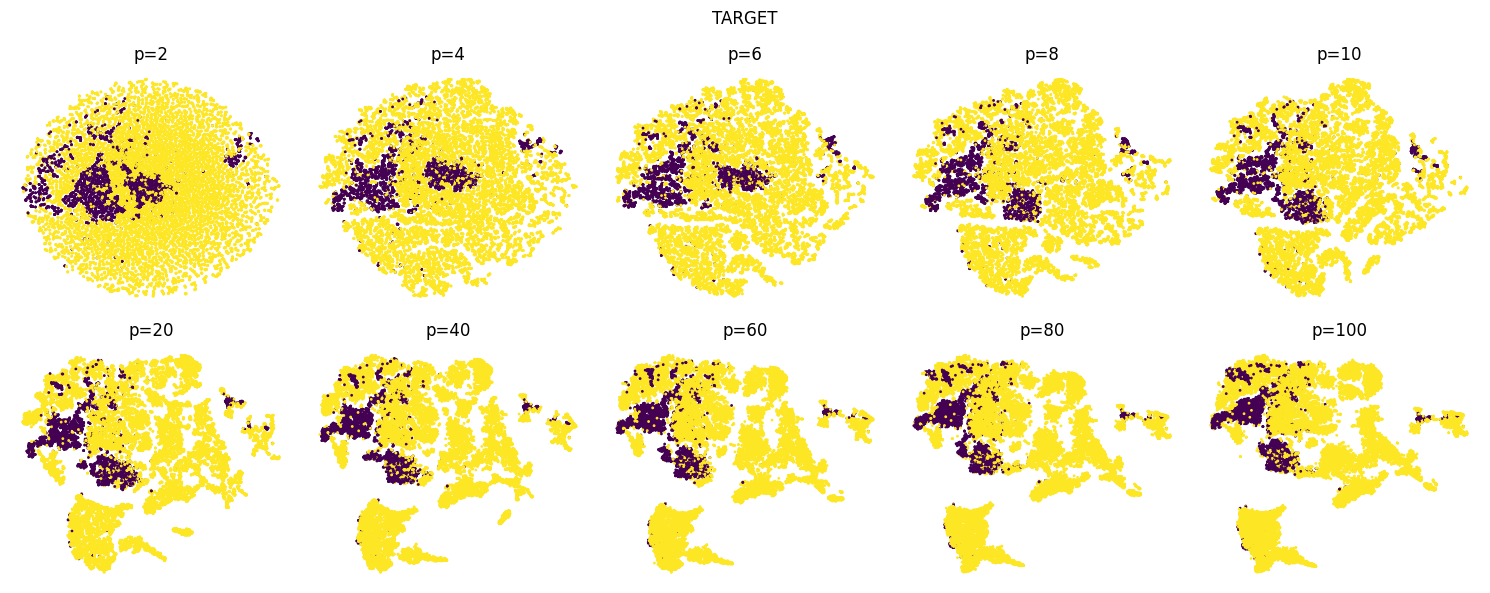

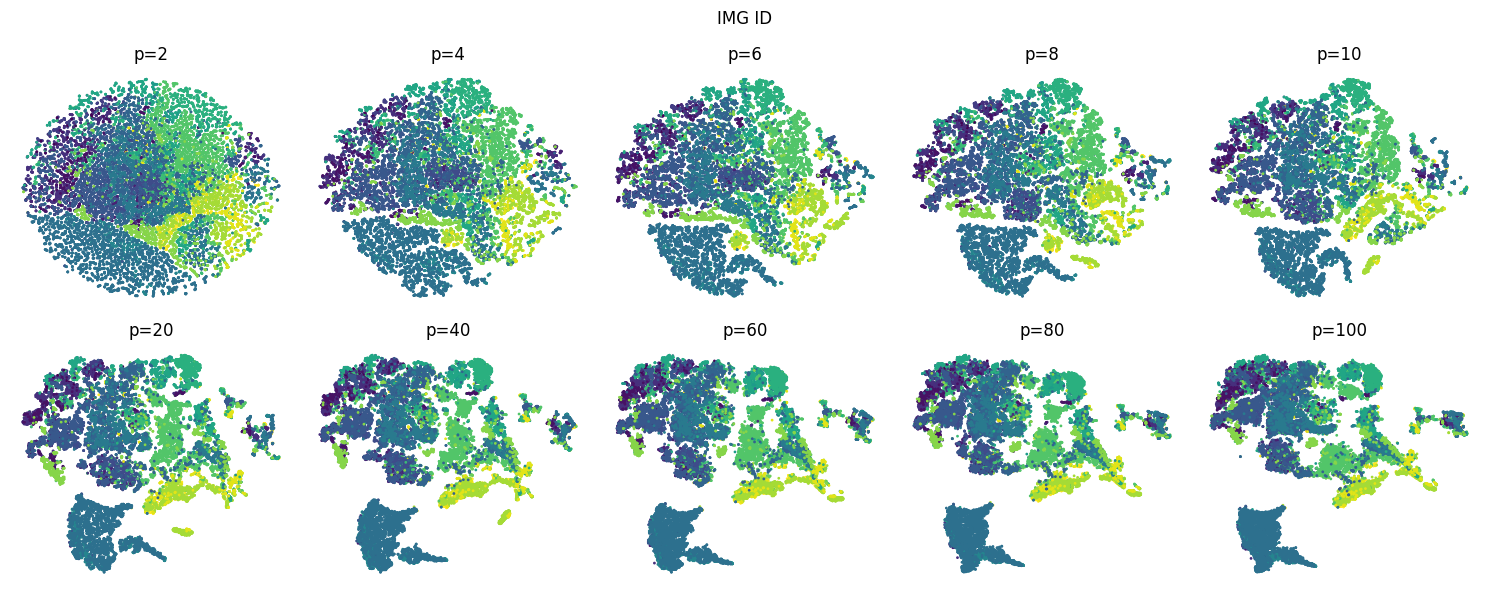

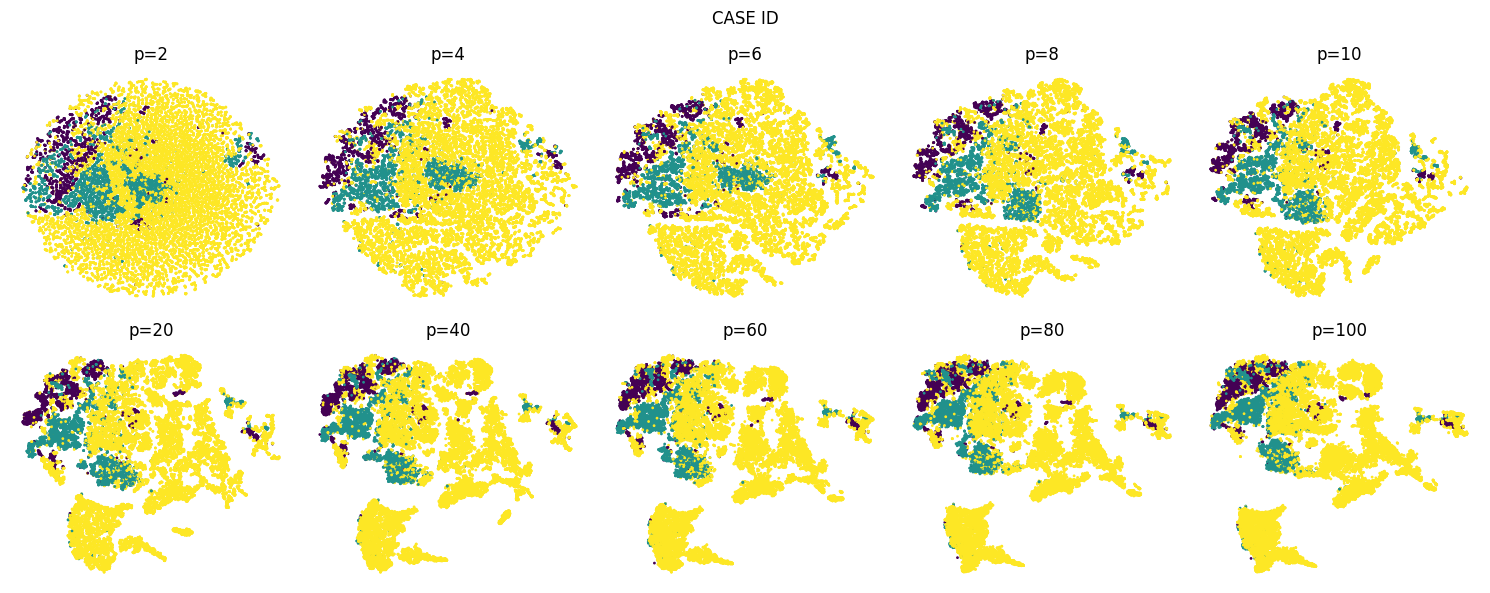

In [35]:
perplexities = [2, 4, 6, 8, 10, 20, 40, 60, 80, 100]

for mapping in ["target", "img id", "case id"]:
    if mapping == "target":
        tags = targets
    elif mapping == "img id":
        tags = img_id_tags
    elif mapping == "case id":
        tags = case_id_tags

    fig, axs = plt.subplots(2, n_plots // 2, figsize=(3 * n_plots // 2, 6))
    fig.suptitle(mapping.upper())
    for i, (p, ax) in enumerate(zip(perplexities, axs.flat)):
        ax.set_title(f"p={p}")
        ax.scatter(*all_tsne[i, :, :].T, s=1, c=tags)
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

Doing the above with an untrained model

In [41]:
from_file=True

Calculating principal components...
Performing T-distributed Stochastic Neighbor Embedding...
Plotting t-SNE...


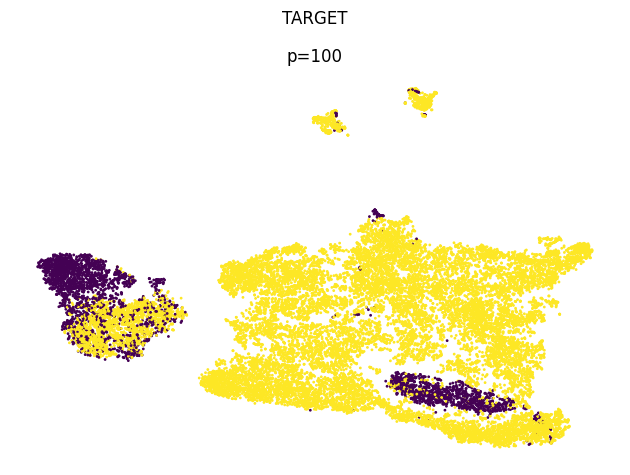

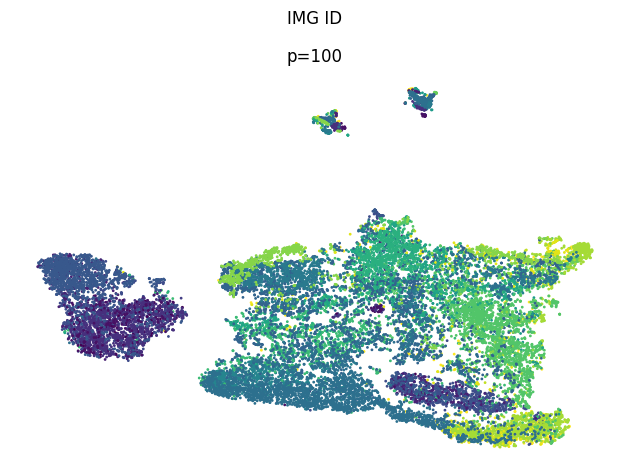

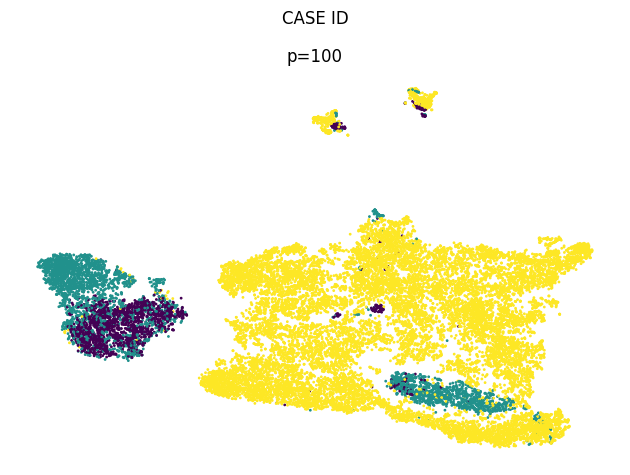

In [48]:
if from_file:
    embeddings_untrained = torch.load(output_dir / "embeddings_untrained.pt")
    targets_untrained = torch.load(output_dir / "targets_untrained.pt")
else:
    model = SimCLR()
    model.to("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    embeddings_untrained, targets_untrained = generate_embeddings(model, dataloader)
    torch.save(embeddings_untrained, output_dir / "embeddings_untrained.pt")
    torch.save(targets_untrained, output_dir / "targets_untrained.pt")

print("Calculating principal components...")
pca_untrained = PCA(10)
pca_embeddings_untrained = pca_untrained.fit_transform(embeddings_untrained.cpu())

print("Performing T-distributed Stochastic Neighbor Embedding...")
perplexity = 100
n_iter = 5000
tsne_untrained = TSNE(perplexity=perplexity, n_iter=n_iter)
if from_file:
    try:
        tsne_embeddings_untrained = np.load(output_dir / f"tsne_embeddings_untrained_{perplexity=}_{n_iter=}.npy")
    except OSError:
        tsne_embeddings_untrained = tsne_untrained.fit_transform(pca_embeddings_untrained)
        np.save(output_dir / f"tsne_embeddings_untrained_{perplexity=}_{n_iter=}.npy", tsne_embeddings_untrained)
else:
    tsne_embeddings_untrained = tsne_untrained.fit_transform(pca_embeddings_untrained)
    np.save(output_dir / f"tsne_embeddings_untrained_{perplexity=}_{n_iter=}.npy", tsne_embeddings_untrained)

print("Plotting t-SNE...")
for mapping in ["target", "img id", "case id"]:
    if mapping == "target":
        tags = targets
    elif mapping == "img id":
        tags = img_id_tags
    elif mapping == "case id":
        tags = case_id_tags

    fig, ax = plt.subplots(1, 1)
    fig.suptitle(mapping.upper())
    ax.set_title(f"p={perplexity}")
    ax.scatter(*tsne_embeddings_untrained.T, s=1, c=tags)
    ax.set_axis_off()

    plt.tight_layout()
    plt.show()